In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier as xgb

from sklearn import preprocessing 

In [2]:
df_errors = pd.read_csv(r"..\data\dataset\ERROR.csv",sep=';')
df_failures = pd.read_csv(r"..\data\dataset\FAILURE.csv",sep=';')
df_machines = pd.read_csv(r"..\data\dataset\MACHINE.csv",sep=';')
df_maint = pd.read_csv(r"..\data\dataset\MANTTO.csv",sep=';')
df_telemetry = pd.read_csv(r"..\data\dataset\SENSOR.csv",sep=';', on_bad_lines='skip')

In [3]:

df_errors["datetime"] = pd.to_datetime(df_errors["datetime"], format="%d/%m/%Y %H:%M")
df_failures["datetime"] = pd.to_datetime(df_failures["datetime"], format="%d/%m/%Y %H:%M")
df_maint["datetime"] = pd.to_datetime(df_maint["datetime"], format="%d/%m/%Y %H:%M")
df_telemetry["datetime"] = pd.to_datetime(df_telemetry["datetime"], format="%d/%m/%Y %H:%M")

### Ingeniería de Características/variables

Media Movil de los datos en la última ventana de 3hrs

In [4]:
temp = []
fields = ["volt", "rotate", "pressure", "vibration"]

In [5]:
temp = [
    pd.pivot_table(
        df_telemetry,
        index="datetime",
        columns="machineID",
        values=col).resample("3H", closed="left", label="right").mean().unstack()
    for col in fields
]
temp[0].head()

machineID  datetime           
1          2021-01-01 09:00:00    177.984768
           2021-01-01 12:00:00    171.183131
           2021-01-01 15:00:00    166.039035
           2021-01-01 18:00:00    175.033434
           2021-01-01 21:00:00    158.352413
dtype: float64

In [6]:
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [col + "mean_3h" for col in fields] 
telemetry_mean_3h.reset_index(inplace=True) 
telemetry_mean_3h.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2021-01-01 09:00:00,177.984768,437.607619,102.575522,40.012143
1,1,2021-01-01 12:00:00,171.183131,366.877598,88.867069,40.666163
2,1,2021-01-01 15:00:00,166.039035,355.048585,103.861628,44.354543
3,1,2021-01-01 18:00:00,175.033434,345.292352,94.769390,39.473830
4,1,2021-01-01 21:00:00,158.352413,447.798406,93.451200,43.226243


In [7]:
df_telemetry.shape

(464333, 6)

In [8]:
telemetry_mean_3h.shape

(137287, 6)

Desviación estándar de la ventana de 3hrs

In [9]:
temp_2 = []

In [10]:
temp_2 = [
    pd.pivot_table(
        df_telemetry,
        index="datetime",
        columns="machineID",
        values=col).resample("3H", closed="left", label="right").std().unstack()
    for col in fields
]
temp_2[0].head()

machineID  datetime           
1          2021-01-01 09:00:00     9.882354
           2021-01-01 12:00:00    19.295075
           2021-01-01 15:00:00     8.819676
           2021-01-01 18:00:00    22.571809
           2021-01-01 21:00:00    16.126607
dtype: float64

In [11]:
telemetry_sd_3h = pd.concat(temp_2, axis=1)
telemetry_sd_3h.columns = [i + "sd_3h" for i in fields]
telemetry_sd_3h.reset_index(inplace=True)
telemetry_sd_3h.head()

,machineID,datetime,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h
0,1,2021-01-01 09:00:00,9.882354,24.555537,9.416220,5.801181
1,1,2021-01-01 12:00:00,19.295075,17.393708,10.594657,3.200587
2,1,2021-01-01 15:00:00,8.819676,22.565357,11.052260,8.379063
3,1,2021-01-01 18:00:00,22.571809,40.857808,10.930532,8.479060
4,1,2021-01-01 21:00:00,16.126607,36.059892,6.187811,6.370973


In [12]:
telemetry_sd_3h.shape

(137287, 6)

Ahora los promedios de 24 horas, y luego seleccionamos el primer resultado cada 3 horas.
De esta manera podremos unir los resultados con las features anteriores de 3hrs.

In [13]:
temp_3 = []

In [14]:
temp_3 = [
    pd.pivot_table(
        df_telemetry,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).mean().resample("3H", closed="left", label="right").first().unstack()
    for col in fields
]
temp_3[0].head()

machineID  datetime           
1          2021-01-01 09:00:00   NaN
           2021-01-01 12:00:00   NaN
           2021-01-01 15:00:00   NaN
           2021-01-01 18:00:00   NaN
           2021-01-01 21:00:00   NaN
dtype: float64

In [15]:
telemetry_mean_24h = pd.concat(temp_3, axis=1)
telemetry_mean_24h.columns = [i + "mean_24h" for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h["voltmean_24h"].isnull()]

In [16]:
telemetry_mean_24h.head(16)

,machineID,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
7,1,2021-01-02 06:00:00,170.299151,410.106823,97.134016,40.959686
8,1,2021-01-02 09:00:00,170.514516,410.496539,96.997006,41.118438
9,1,2021-01-02 12:00:00,171.619836,420.734019,97.525164,41.159908
10,1,2021-01-02 15:00:00,169.429630,432.332198,97.348955,41.039213
11,1,2021-01-02 18:00:00,168.729852,439.039268,96.684887,40.511113
12,1,2021-01-02 21:00:00,167.219631,454.674961,99.391370,40.251660
13,1,2021-01-03 00:00:00,170.483861,453.801839,99.339377,40.257151
14,1,2021-01-03 03:00:00,169.455373,450.998222,98.996711,39.617433
15,1,2021-01-03 06:00:00,171.344285,445.074402,99.603981,39.024653
16,1,2021-01-03 09:00:00,168.735391,441.759687,99.253672,38.549589


Ahora las desviaciones estándar de 24 horas, y luego seleccionamos el primer resultado cada 3 horas. De esta manera podremos unir los resultados con las features anteriores de 3hrs.

In [17]:
temp_4 = []

temp_4 = [
    pd.pivot_table(
        df_telemetry,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).std().resample("3H", closed="left", label="right").first().unstack(level=-1)
    for col in fields
]
temp_4[0].head()

machineID  datetime           
1          2021-01-01 09:00:00   NaN
           2021-01-01 12:00:00   NaN
           2021-01-01 15:00:00   NaN
           2021-01-01 18:00:00   NaN
           2021-01-01 21:00:00   NaN
dtype: float64

In [18]:
telemetry_sd_24h = pd.concat(temp_4, axis=1)
telemetry_sd_24h.columns = [i + "sd_24h" for i in fields]
telemetry_sd_24h.reset_index(inplace=True)
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h["voltsd_24h"].isnull()]

In [19]:
telemetry_sd_24h.head(10)

,machineID,datetime,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2021-01-02 06:00:00,16.490101,53.500713,8.429203,5.530246
8,1,2021-01-02 09:00:00,16.486754,53.793502,8.306793,5.603681
9,1,2021-01-02 12:00:00,18.262938,58.189640,6.959186,5.377798
10,1,2021-01-02 15:00:00,18.900670,55.478868,6.771459,5.127402
11,1,2021-01-02 18:00:00,19.800134,55.121375,5.484112,4.932281
12,1,2021-01-02 21:00:00,18.751248,50.870861,6.478913,5.417204
13,1,2021-01-03 00:00:00,18.551911,51.442506,7.225496,5.446365
14,1,2021-01-03 03:00:00,17.917417,52.939298,7.750587,5.768885
15,1,2021-01-03 06:00:00,18.003726,58.935557,7.959774,6.340399
16,1,2021-01-03 09:00:00,16.655843,58.225785,8.259809,6.140394


In [20]:
telemetry_feat = pd.concat([
    telemetry_mean_3h,
    telemetry_sd_3h.iloc[:, 2:6],
    telemetry_mean_24h.iloc[:, 2:6],
    telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2021-01-02 06:00:00,180.857530,470.172113,94.280586,42.585979,22.634509,22.853920,1.881499,6.693348,170.299151,410.106823,97.134016,40.959686,16.490101,53.500713,8.429203,5.530246
8,1,2021-01-02 09:00:00,190.106712,472.050647,101.401050,41.230043,15.099202,19.501492,2.798117,4.135271,170.514516,410.496539,96.997006,41.118438,16.486754,53.793502,8.306793,5.603681
9,1,2021-01-02 12:00:00,156.143089,473.039256,94.087971,45.381425,15.992174,62.777583,4.986140,5.430938,171.619836,420.734019,97.525164,41.159908,18.262938,58.189640,6.959186,5.377798
10,1,2021-01-02 15:00:00,158.458223,422.208281,98.615362,38.839316,19.404615,83.613846,4.573212,2.846899,169.429630,432.332198,97.348955,41.039213,18.900670,55.478868,6.771459,5.127402
11,1,2021-01-02 18:00:00,160.116287,444.272739,107.573098,36.189106,10.283735,32.058147,10.977006,1.199312,168.729852,439.039268,96.684887,40.511113,19.800134,55.121375,5.484112,4.932281


In [21]:
telemetry_feat.describe()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,136911.00000,136911,136911.000000,136911.000000,136911.000000,136911.000000,136911.000000,136911.000000,136911.000000,136911.000000,136911.000000,136911.000000,136911.000000,136911.000000,136911.000000,136911.000000,136911.000000,136911.000000
mean,24.00000,2021-07-03 06:00:00,170.748936,446.646166,100.852720,40.389636,13.319198,44.419563,8.878863,4.439653,170.750583,446.644701,100.853336,40.389519,14.916940,49.950608,10.045689,4.997556
min,1.00000,2021-01-02 06:00:00,125.532506,211.811184,73.951948,26.569635,0.025509,0.078991,0.043181,0.015278,156.645540,266.010419,91.556695,35.060087,7.100851,21.914634,4.145308,2.333070
25%,12.00000,2021-04-03 06:00:00,164.445378,427.627601,96.252877,38.150964,8.032612,26.894218,5.350282,2.683167,168.045919,441.583413,98.683368,39.365028,13.355872,44.672948,8.914856,4.455703
50%,24.00000,2021-07-03 06:00:00,170.412737,448.365706,100.214078,40.148966,12.503692,41.754574,8.345720,4.178054,170.198270,449.294257,100.106202,40.078854,14.851148,49.608438,9.919416,4.954330
75%,36.00000,2021-10-02 06:00:00,176.608780,468.505166,104.446567,42.234213,17.706062,59.052009,11.773637,5.899558,172.457274,456.407417,101.617514,40.840499,16.388642,54.819602,10.984902,5.479479
max,47.00000,2022-01-01 06:00:00,228.679545,586.682904,162.298051,66.535850,58.444332,179.637880,34.380664,18.305595,209.508635,495.814467,152.215627,61.153180,27.335132,103.819404,21.646154,10.162724
std,13.56471,NaN,9.449074,33.205146,7.376022,3.463897,6.980374,23.201293,4.657461,2.317883,4.676296,18.158506,4.678871,2.043183,2.263075,7.658553,1.719286,0.797843


Aplicamos un One Hot Encode a la columna de errorID para obtener más características.

In [22]:
df = df_errors.sort_values(by=['datetime'])

OHE_df = pd.get_dummies(df, columns =  ["errorID"], dtype=int)

OHE_df.columns = ["datetime", "machineID", "error1", "error2", "error3", "error4", "error5"]

In [23]:
OHE_df.head(15)

,datetime,machineID,error1,error2,error3,error4,error5
1160,2021-01-01 06:00:00,4,0,0,0,1,0
206,2021-01-01 08:00:00,9,0,0,0,1,0
627,2021-01-01 10:00:00,24,0,1,0,0,0
1118,2021-01-01 12:00:00,1,0,1,0,0,0
1740,2021-01-01 12:00:00,16,0,0,1,0,0
161,2021-01-01 20:00:00,31,1,0,0,0,0
331,2021-01-02 04:00:00,47,0,1,0,0,0
767,2021-01-02 13:00:00,43,0,0,1,0,0
967,2021-01-03 02:00:00,27,0,1,0,0,0
1119,2021-01-03 04:00:00,1,1,0,0,0,0


In [24]:
OHE_df.sort_values(by=['datetime']).head(18)

#1830 filas

,datetime,machineID,error1,error2,error3,error4,error5
1160,2021-01-01 06:00:00,4,0,0,0,1,0
206,2021-01-01 08:00:00,9,0,0,0,1,0
627,2021-01-01 10:00:00,24,0,1,0,0,0
1118,2021-01-01 12:00:00,1,0,1,0,0,0
1740,2021-01-01 12:00:00,16,0,0,1,0,0
161,2021-01-01 20:00:00,31,1,0,0,0,0
331,2021-01-02 04:00:00,47,0,1,0,0,0
767,2021-01-02 13:00:00,43,0,0,1,0,0
967,2021-01-03 02:00:00,27,0,1,0,0,0
1119,2021-01-03 04:00:00,1,1,0,0,0,0


In [25]:
error_count_grouped = OHE_df.groupby(["machineID", "datetime"]).sum().reset_index()
error_count_grouped.head(15)

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2021-01-01 12:00:00,0,1,0,0,0
1,1,2021-01-03 04:00:00,1,0,0,0,0
2,1,2021-01-17 17:00:00,0,0,0,1,0
3,1,2021-02-15 03:00:00,0,0,1,0,0
4,1,2021-02-25 05:00:00,1,0,0,0,0
5,1,2021-02-25 07:00:00,0,0,1,0,0
6,1,2021-03-23 06:00:00,1,0,0,0,0
7,1,2021-04-21 03:00:00,1,0,0,0,0
8,1,2021-04-26 02:00:00,0,0,1,0,0
9,1,2021-04-29 03:00:00,0,0,1,0,0


Nos aseguramos que los errores que se tienen el el dataframe df_errors estén relacionados con el dataframe df_telemetry, osease que no haya errores de df_errors que los sensores del df_telemetry no hayan captado, por ejemplo, si se captura un error del día 01/08/2024 pero el df_telemetry no tiene un record con dicha fecha, entonces no podemos saber cuál fue la razón del error.

In [26]:
df_telemetry.loc[df_telemetry.datetime=="2021-01-01 06:00:00","datetime"]

0        2021-01-01 06:00:00
8761     2021-01-01 06:00:00
17522    2021-01-01 06:00:00
26283    2021-01-01 06:00:00
35044    2021-01-01 06:00:00
43805    2021-01-01 06:00:00
52566    2021-01-01 06:00:00
61327    2021-01-01 06:00:00
70088    2021-01-01 06:00:00
78849    2021-01-01 06:00:00
87610    2021-01-01 06:00:00
96371    2021-01-01 06:00:00
105132   2021-01-01 06:00:00
113893   2021-01-01 06:00:00
122654   2021-01-01 06:00:00
131415   2021-01-01 06:00:00
140176   2021-01-01 06:00:00
148937   2021-01-01 06:00:00
157698   2021-01-01 06:00:00
166459   2021-01-01 06:00:00
175220   2021-01-01 06:00:00
183981   2021-01-01 06:00:00
192742   2021-01-01 06:00:00
201503   2021-01-01 06:00:00
210264   2021-01-01 06:00:00
219025   2021-01-01 06:00:00
227786   2021-01-01 06:00:00
236547   2021-01-01 06:00:00
245308   2021-01-01 06:00:00
254069   2021-01-01 06:00:00
262830   2021-01-01 06:00:00
271591   2021-01-01 06:00:00
280352   2021-01-01 06:00:00
289113   2021-01-01 06:00:00
297874   2021-

In [27]:
error_count_filtered = df_telemetry[["datetime", "machineID"]].merge(
    error_count_grouped,
    on=["machineID", "datetime"],
    how="left"
).fillna(0.0)

error_count_filtered.head()

,datetime,machineID,error1,error2,error3,error4,error5
0,2021-01-01 06:00:00,42,0.0,0.0,0.0,0.0,0.0
1,2021-01-01 07:00:00,42,0.0,0.0,0.0,0.0,0.0
2,2021-01-01 08:00:00,42,0.0,0.0,0.0,0.0,0.0
3,2021-01-01 09:00:00,42,0.0,0.0,0.0,0.0,0.0
4,2021-01-01 10:00:00,42,0.0,0.0,0.0,0.0,0.0


In [28]:
temp_5 = []
fields = ["error1","error2","error3","error4","error5"]

temp_5 = [
    pd.pivot_table(
        error_count_filtered,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).sum().resample("3H", closed="left", label="right").first().unstack()
    for col in fields
]

temp_5[0].head(10)

machineID  datetime           
1          2021-01-01 09:00:00    NaN
           2021-01-01 12:00:00    NaN
           2021-01-01 15:00:00    NaN
           2021-01-01 18:00:00    NaN
           2021-01-01 21:00:00    NaN
           2021-01-02 00:00:00    NaN
           2021-01-02 03:00:00    NaN
           2021-01-02 06:00:00    0.0
           2021-01-02 09:00:00    0.0
           2021-01-02 12:00:00    0.0
dtype: float64

In [29]:
error_count_total = pd.concat(temp_5, axis=1)
error_count_total.columns = [i + "_count" for i in fields]
error_count_total.reset_index(inplace=True)
## Chau errores que no tienen data de telemetry.
error_count_total = error_count_total.dropna()
error_count_total.head()

,machineID,datetime,error1_count,error2_count,error3_count,error4_count,error5_count
7,1,2021-01-02 06:00:00,0.0,1.0,0.0,0.0,0.0
8,1,2021-01-02 09:00:00,0.0,1.0,0.0,0.0,0.0
9,1,2021-01-02 12:00:00,0.0,1.0,0.0,0.0,0.0
10,1,2021-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2021-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


In [30]:
error_count_total.shape

(136958, 7)

In [31]:
error_count_total["error1_count"].unique()

array([0., 1., 2.])

In [32]:
error_count_total.describe()

,machineID,datetime,error1_count,error2_count,error3_count,error4_count,error5_count
count,136958.000000,136958,136958.000000,136958.000000,136958.000000,136958.000000,136958.000000
mean,24.000000,2021-07-03 07:30:00,0.028724,0.026512,0.022525,0.018984,0.009872
min,1.000000,2021-01-02 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,2021-04-03 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,2021-07-03 07:30:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,36.000000,2021-10-02 09:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,47.000000,2022-01-01 09:00:00,2.000000,2.000000,2.000000,2.000000,2.000000
std,13.564709,NaN,0.169375,0.162370,0.150048,0.137641,0.099380


Reemplazos, esta característica nos pueda ayudar a saber si el tiempo desde que se reemplazó un componente de alguna máquina influye en un posible error. Lo lógico en la ingeniería de mantenimiento es que si un componente no se cambió en mucho tiempo, entonces este tenga una mayor probabilidad de fallar.

En este caso Part_1	Part_2	Part_3	Part_4 son las variables que significarán el tiempo desde el último mantienimeinto del componente o parte.

In [33]:
df_maint.head()

,datetime,machineID,comp
0,2020-07-31,1,PART01
1,2020-08-30,1,PART04
2,2020-10-29,1,PART02
3,2020-11-28,1,PART03
4,2021-01-23,1,PART03


In [34]:
 

df_maint_2 = pd.get_dummies(df_maint, columns =  ["comp"], dtype=int)
df_maint_2.columns = ["datetime", "machineID", "Part_1", "Part_2", "Part_3", "Part_4"]
df_maint_2.head()

,datetime,machineID,Part_1,Part_2,Part_3,Part_4
0,2020-07-31,1,1,0,0,0
1,2020-08-30,1,0,0,0,1
2,2020-10-29,1,0,1,0,0
3,2020-11-28,1,0,0,1,0
4,2021-01-23,1,0,0,1,0


In [35]:
df_maint_2 = df_maint_2.groupby(["machineID", "datetime"]).sum().reset_index()
df_maint_2.head()

,machineID,datetime,Part_1,Part_2,Part_3,Part_4
0,1,2020-07-31,1,0,0,0
1,1,2020-08-30,0,0,0,1
2,1,2020-10-29,0,1,0,0
3,1,2020-11-28,0,0,1,0
4,1,2021-01-23,0,0,1,0


In [36]:
df_maint_2 = df_telemetry[["datetime", "machineID"]].merge(
    df_maint_2,
    on=["datetime", "machineID"],
    how="outer").fillna(0).sort_values(by=["machineID", "datetime"]
)
df_maint_2.head()

,datetime,machineID,Part_1,Part_2,Part_3,Part_4
464333,2020-07-31 00:00:00,1,1.0,0.0,0.0,0.0
464334,2020-08-30 00:00:00,1,0.0,0.0,0.0,1.0
464335,2020-10-29 00:00:00,1,0.0,1.0,0.0,0.0
464336,2020-11-28 00:00:00,1,0.0,0.0,1.0,0.0
315396,2021-01-01 06:00:00,1,0.0,0.0,0.0,0.0


In [37]:
components = ["Part_1", "Part_2", "Part_3", "Part_4"]
for comp in components:
    df_maint_2.loc[df_maint_2[comp] < 1, comp] = None
    df_maint_2.loc[-df_maint_2[comp].isnull(), comp] = df_maint_2.loc[-df_maint_2[comp].isnull(), "datetime"]
    df_maint_2[comp] = pd.to_datetime(df_maint_2[comp].fillna(method="ffill"))

df_maint_2 = df_maint_2.loc[df_maint_2["datetime"] > pd.to_datetime("2021-01-01")]

In [38]:
df_maint_2.head(15)

,datetime,machineID,Part_1,Part_2,Part_3,Part_4
315396,2021-01-01 06:00:00,1,2020-07-31,2020-10-29,2020-11-28,2020-08-30
315397,2021-01-01 07:00:00,1,2020-07-31,2020-10-29,2020-11-28,2020-08-30
315398,2021-01-01 08:00:00,1,2020-07-31,2020-10-29,2020-11-28,2020-08-30
315399,2021-01-01 09:00:00,1,2020-07-31,2020-10-29,2020-11-28,2020-08-30
315400,2021-01-01 10:00:00,1,2020-07-31,2020-10-29,2020-11-28,2020-08-30
315401,2021-01-01 11:00:00,1,2020-07-31,2020-10-29,2020-11-28,2020-08-30
315402,2021-01-01 12:00:00,1,2020-07-31,2020-10-29,2020-11-28,2020-08-30
315403,2021-01-01 13:00:00,1,2020-07-31,2020-10-29,2020-11-28,2020-08-30
315404,2021-01-01 14:00:00,1,2020-07-31,2020-10-29,2020-11-28,2020-08-30
315405,2021-01-01 15:00:00,1,2020-07-31,2020-10-29,2020-11-28,2020-08-30


In [39]:
for comp in components: 
    df_maint_2[comp] = (df_maint_2["datetime"] - pd.to_datetime(df_maint_2[comp])) / np.timedelta64(1, "D")
    
df_maint_2.head()

,datetime,machineID,Part_1,Part_2,Part_3,Part_4
315396,2021-01-01 06:00:00,1,154.250000,64.250000,34.250000,124.250000
315397,2021-01-01 07:00:00,1,154.291667,64.291667,34.291667,124.291667
315398,2021-01-01 08:00:00,1,154.333333,64.333333,34.333333,124.333333
315399,2021-01-01 09:00:00,1,154.375000,64.375000,34.375000,124.375000
315400,2021-01-01 10:00:00,1,154.416667,64.416667,34.416667,124.416667


In [40]:
df_maint_2.describe()

,datetime,machineID,Part_1,Part_2,Part_3,Part_4
count,464333,464333.000000,464333.000000,464333.000000,464333.000000,464333.000000
mean,2021-07-02 18:00:00.000000256,24.188679,50.106600,52.663054,50.951663,52.801491
min,2021-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2021-04-02 12:00:00,12.000000,13.166667,11.500000,13.125000,13.083333
50%,2021-07-02 18:00:00,25.000000,32.416667,28.291667,31.916667,32.250000
75%,2021-10-02 00:00:00,36.000000,66.833333,65.916667,64.708333,66.041667
max,2022-01-01 06:00:00,47.000000,315.958333,339.958333,318.958333,394.958333
std,NaN,13.878268,53.414572,63.784628,56.752044,60.685702


Durante esta etapa de ingeniería de datos, podemos ver que la "parte2" es la que se cambia en periodos más largos de tiempo, sin embargo, es la que más falla, acá quizás podamos ver algún tipo de correlación entre "fallas" y "mantto de las partes", específicamente de la "part2".

In [41]:
## Concatenamos el DF de "máquinas"

pre_final_feat = telemetry_feat.merge(error_count_total, on=["datetime", "machineID"], how="left")
pre_final_feat = pre_final_feat.merge(df_maint_2, on=["datetime", "machineID"], how="left")
pre_final_feat = pre_final_feat.merge(df_machines, on=["machineID"], how="left")
pre_final_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error2_count,error3_count,error4_count,error5_count,Part_1,Part_2,Part_3,Part_4,model,age
0,1,2021-01-02 06:00:00,180.857530,470.172113,94.280586,42.585979,22.634509,22.853920,1.881499,6.693348,...,1.0,0.0,0.0,0.0,155.250,65.250,35.250,125.250,JACQUARD TF,2
1,1,2021-01-02 09:00:00,190.106712,472.050647,101.401050,41.230043,15.099202,19.501492,2.798117,4.135271,...,1.0,0.0,0.0,0.0,155.375,65.375,35.375,125.375,JACQUARD TF,2
2,1,2021-01-02 12:00:00,156.143089,473.039256,94.087971,45.381425,15.992174,62.777583,4.986140,5.430938,...,1.0,0.0,0.0,0.0,155.500,65.500,35.500,125.500,JACQUARD TF,2
3,1,2021-01-02 15:00:00,158.458223,422.208281,98.615362,38.839316,19.404615,83.613846,4.573212,2.846899,...,0.0,0.0,0.0,0.0,155.625,65.625,35.625,125.625,JACQUARD TF,2
4,1,2021-01-02 18:00:00,160.116287,444.272739,107.573098,36.189106,10.283735,32.058147,10.977006,1.199312,...,0.0,0.0,0.0,0.0,155.750,65.750,35.750,125.750,JACQUARD TF,2


In [42]:
pre_final_feat.head(2)

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error2_count,error3_count,error4_count,error5_count,Part_1,Part_2,Part_3,Part_4,model,age
0,1,2021-01-02 06:00:00,180.857530,470.172113,94.280586,42.585979,22.634509,22.853920,1.881499,6.693348,...,1.0,0.0,0.0,0.0,155.250,65.250,35.250,125.250,JACQUARD TF,2
1,1,2021-01-02 09:00:00,190.106712,472.050647,101.401050,41.230043,15.099202,19.501492,2.798117,4.135271,...,1.0,0.0,0.0,0.0,155.375,65.375,35.375,125.375,JACQUARD TF,2


In [43]:
pre_final_feat.shape

(154389, 29)

Pasamos a ONE HOT ENCODE a la columna MODEL (que es la columna de modelo de máquina)


In [44]:
final_df = pd.get_dummies(pre_final_feat, columns = ["model"], dtype=int)

In [45]:
final_df.head(2)

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error5_count,Part_1,Part_2,Part_3,Part_4,age,model_ALPHA 560 UNIVERSAL,model_JACQUARD TF,model_NOVA 62,model_NOVA 6HS
0,1,2021-01-02 06:00:00,180.857530,470.172113,94.280586,42.585979,22.634509,22.853920,1.881499,6.693348,...,0.0,155.250,65.250,35.250,125.250,2,0,1,0,0
1,1,2021-01-02 09:00:00,190.106712,472.050647,101.401050,41.230043,15.099202,19.501492,2.798117,4.135271,...,0.0,155.375,65.375,35.375,125.375,2,0,1,0,0


In [46]:
final_df.shape

(154389, 32)

In [47]:
print(final_df.columns)

Index(['machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1_count', 'error2_count',
       'error3_count', 'error4_count', 'error5_count', 'Part_1', 'Part_2',
       'Part_3', 'Part_4', 'age', 'model_ALPHA 560 UNIVERSAL',
       'model_JACQUARD TF', 'model_NOVA 62', 'model_NOVA 6HS'],
      dtype='object')


In [48]:
pd.set_option('display.max_columns', 150)

In [49]:
final_df.head(2)

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h,error1_count,error2_count,error3_count,error4_count,error5_count,Part_1,Part_2,Part_3,Part_4,age,model_ALPHA 560 UNIVERSAL,model_JACQUARD TF,model_NOVA 62,model_NOVA 6HS
0,1,2021-01-02 06:00:00,180.857530,470.172113,94.280586,42.585979,22.634509,22.853920,1.881499,6.693348,170.299151,410.106823,97.134016,40.959686,16.490101,53.500713,8.429203,5.530246,0.0,1.0,0.0,0.0,0.0,155.250,65.250,35.250,125.250,2,0,1,0,0
1,1,2021-01-02 09:00:00,190.106712,472.050647,101.401050,41.230043,15.099202,19.501492,2.798117,4.135271,170.514516,410.496539,96.997006,41.118438,16.486754,53.793502,8.306793,5.603681,0.0,1.0,0.0,0.0,0.0,155.375,65.375,35.375,125.375,2,0,1,0,0


In [50]:
final_df.shape

(154389, 32)

In [51]:
df_failures.sort_values(by=['machineID']).head(2)

,datetime,machineID,failure
217,2021-03-24 06:00:00,1,PART01
218,2021-09-05 06:00:00,1,PART01


Unimos las failures al dataset, estas failures son nuestra Target

In [52]:
final_df_labels = final_df.merge(df_failures, on=["datetime", "machineID"], how="left")

final_df_labels["failure"] = final_df_labels["failure"].astype(object).fillna(method="bfill", limit=7)
final_df_labels["failure"] = final_df_labels["failure"].fillna("none")
final_df_labels["failure"] = final_df_labels["failure"].astype("category")
final_df_labels.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h,error1_count,error2_count,error3_count,error4_count,error5_count,Part_1,Part_2,Part_3,Part_4,age,model_ALPHA 560 UNIVERSAL,model_JACQUARD TF,model_NOVA 62,model_NOVA 6HS,failure
0,1,2021-01-02 06:00:00,180.857530,470.172113,94.280586,42.585979,22.634509,22.853920,1.881499,6.693348,170.299151,410.106823,97.134016,40.959686,16.490101,53.500713,8.429203,5.530246,0.0,1.0,0.0,0.0,0.0,155.250,65.250,35.250,125.250,2,0,1,0,0,none
1,1,2021-01-02 09:00:00,190.106712,472.050647,101.401050,41.230043,15.099202,19.501492,2.798117,4.135271,170.514516,410.496539,96.997006,41.118438,16.486754,53.793502,8.306793,5.603681,0.0,1.0,0.0,0.0,0.0,155.375,65.375,35.375,125.375,2,0,1,0,0,none
2,1,2021-01-02 12:00:00,156.143089,473.039256,94.087971,45.381425,15.992174,62.777583,4.986140,5.430938,171.619836,420.734019,97.525164,41.159908,18.262938,58.189640,6.959186,5.377798,0.0,1.0,0.0,0.0,0.0,155.500,65.500,35.500,125.500,2,0,1,0,0,none
3,1,2021-01-02 15:00:00,158.458223,422.208281,98.615362,38.839316,19.404615,83.613846,4.573212,2.846899,169.429630,432.332198,97.348955,41.039213,18.900670,55.478868,6.771459,5.127402,0.0,0.0,0.0,0.0,0.0,155.625,65.625,35.625,125.625,2,0,1,0,0,none
4,1,2021-01-02 18:00:00,160.116287,444.272739,107.573098,36.189106,10.283735,32.058147,10.977006,1.199312,168.729852,439.039268,96.684887,40.511113,19.800134,55.121375,5.484112,4.932281,0.0,0.0,0.0,0.0,0.0,155.750,65.750,35.750,125.750,2,0,1,0,0,none


In [53]:
final_df_labels.shape
## Hay explosión cartesiana, baja pero lo hay.

(154406, 33)

###### Buscar si hay Multicolinealidad

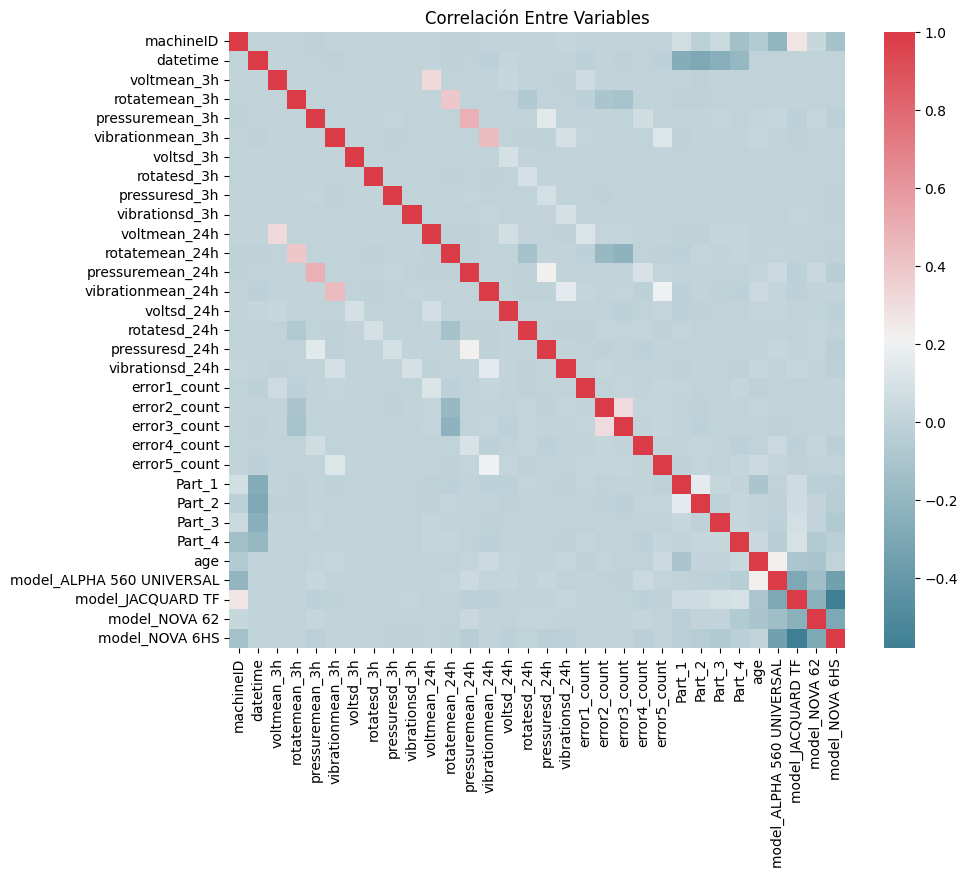

In [54]:
f, ax = plt.subplots(figsize=(10, 8))
corr = final_df_labels.iloc[:,:-1].corr()
sns.heatmap(corr, mask=np.zeros_like(corr), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title("Correlación Entre Variables")
plt.show()

Según el gráfico no existe ningún problema de **multicolinealidad**, no existe correlación entre variables predictoras (features)

In [55]:
final_df_labels.to_csv("final_df_labels.csv", sep=',', index=False)

### MODELADO

In [56]:
final_df_labels_2 = pd.read_csv(r"final_df_labels.csv")

In [57]:
final_df_labels_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154406 entries, 0 to 154405
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   machineID                  154406 non-null  int64  
 1   datetime                   154406 non-null  object 
 2   voltmean_3h                154406 non-null  float64
 3   rotatemean_3h              154406 non-null  float64
 4   pressuremean_3h            154406 non-null  float64
 5   vibrationmean_3h           154406 non-null  float64
 6   voltsd_3h                  154406 non-null  float64
 7   rotatesd_3h                154406 non-null  float64
 8   pressuresd_3h              154406 non-null  float64
 9   vibrationsd_3h             154406 non-null  float64
 10  voltmean_24h               154406 non-null  float64
 11  rotatemean_24h             154406 non-null  float64
 12  pressuremean_24h           154406 non-null  float64
 13  vibrationmean_24h          15

In [58]:
final_df_labels_2["datetime"] = pd.to_datetime(final_df_labels_2["datetime"], format="%Y-%m-%d %H:%M:%S")

# 2021-01-02 06:00:00

In [59]:
final_df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154406 entries, 0 to 154405
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   machineID                  154406 non-null  int64         
 1   datetime                   154406 non-null  datetime64[ns]
 2   voltmean_3h                154406 non-null  float64       
 3   rotatemean_3h              154406 non-null  float64       
 4   pressuremean_3h            154406 non-null  float64       
 5   vibrationmean_3h           154406 non-null  float64       
 6   voltsd_3h                  154406 non-null  float64       
 7   rotatesd_3h                154406 non-null  float64       
 8   pressuresd_3h              154406 non-null  float64       
 9   vibrationsd_3h             154406 non-null  float64       
 10  voltmean_24h               154406 non-null  float64       
 11  rotatemean_24h             154406 non-null  float64 

In [60]:
final_df_labels.describe()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h,error1_count,error2_count,error3_count,error4_count,error5_count,Part_1,Part_2,Part_3,Part_4,age,model_ALPHA 560 UNIVERSAL,model_JACQUARD TF,model_NOVA 62,model_NOVA 6HS
count,154406.000000,154406,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000,154406.000000
mean,24.189021,2021-07-03 05:56:48.629198336,170.737328,446.630071,100.824084,40.384851,13.319525,44.401802,8.868878,4.438182,170.739095,446.628279,100.825082,40.384997,14.916057,49.938756,10.035275,4.994782,0.028632,0.026638,0.022519,0.018419,0.009287,49.911593,52.404424,50.749242,52.571153,10.830350,0.150959,0.320758,0.113215,0.415068
min,1.000000,2021-01-02 06:00:00,125.532506,211.811184,73.951948,26.569635,0.025509,0.078991,0.043181,0.015278,156.645540,266.010419,91.556695,35.060087,7.100851,21.914634,4.145308,2.333070,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,2021-04-03 06:00:00,164.436951,427.599581,96.235947,38.155272,8.029099,26.879250,5.344680,2.682179,168.040016,441.608768,98.673972,39.369792,13.350115,44.664427,8.907910,4.453337,0.000000,0.000000,0.000000,0.000000,0.000000,13.125000,11.375000,13.125000,13.000000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,2021-07-03 06:00:00,170.395369,448.393288,100.200259,40.146202,12.497552,41.764406,8.337897,4.177411,170.190875,449.323863,100.094217,40.082363,14.847560,49.609907,9.913262,4.952285,0.000000,0.000000,0.000000,0.000000,0.000000,32.250000,28.125000,31.750000,32.125000,10.000000,0.000000,0.000000,0.000000,0.000000
75%,36.000000,2021-10-02 06:00:00,176.593409,468.477268,104.428063,42.232505,17.708083,59.016518,11.759020,5.900687,172.443622,456.411557,101.603986,40.840136,16.393391,54.797277,10.975370,5.476198,0.000000,0.000000,0.000000,0.000000,0.000000,66.500000,65.500000,64.500000,65.750000,16.000000,0.000000,1.000000,0.000000,1.000000
max,47.000000,2022-01-01 06:00:00,228.679545,586.682904,162.298051,66.535850,58.444332,179.637880,34.380664,18.305595,209.508635,495.814467,152.215627,61.153180,27.335132,103.819404,21.646154,10.162724,2.000000,2.000000,2.000000,2.000000,2.000000,315.875000,339.875000,318.875000,394.875000,20.000000,1.000000,1.000000,1.000000,1.000000
std,13.878233,NaN,9.443919,33.241003,7.342011,3.452367,6.984298,23.193107,4.651587,2.317079,4.670057,18.227687,4.633888,2.028035,2.269700,7.651093,1.710585,0.796347,0.168855,0.162543,0.149840,0.135517,0.096393,53.279712,63.637131,56.634312,60.575753,5.548277,0.358010,0.466770,0.316856,0.492735


In [61]:
# Pto quiebre: Dividmos el dataset en las primeras fechas para training y el para Testing
threshold_dates = [
    pd.to_datetime("2021-09-30 01:00:00"), pd.to_datetime("2021-10-01 01:00:00")
]

In [62]:
threshold_dates

[Timestamp('2021-09-30 01:00:00'), Timestamp('2021-10-01 01:00:00')]

In [63]:
test_results = []
models = []
total = len(threshold_dates)

last_train_date = threshold_dates[0]
first_test_date = threshold_dates[1]

In [64]:
ntraining = final_df_labels.loc[final_df_labels["datetime"] < last_train_date]
ntesting = final_df_labels.loc[final_df_labels["datetime"] > first_test_date]
print(f"{ntraining.shape[0]} para training.")
print(f"{ntesting.shape[0]} para testing")
print(f"{ntesting.shape[0] / ntraining.shape[0] * 100:0.1f}% de los datos se usarán para pruebas.")

114865 para training.
39117 para testing
34.1% de los datos se usarán para pruebas.


In [65]:
fails_train = ntraining[ntraining["failure"] != "none"].shape[0]
no_fails_train = ntraining[ntraining["failure"] == "none"].shape[0]
fails_test = ntesting[ntesting["failure"] != "none"].shape[0]
no_fails_test = ntesting[ntesting["failure"] == "none"].shape[0]

print(f"{fails_train / no_fails_train * 100:0.1f}% de los casos son fallas en set de entrenamiento.")
print(f"{fails_test / no_fails_test * 100:0.1f}% de los casos son fallas en set de pruebas.")

1.8% de los casos son fallas en set de entrenamiento.
1.6% de los casos son fallas en set de pruebas.


Nos deshacemos de la data datetime, machineID, y failure para los conjuntos de "*features*".
La razón por la cual se bota el "datetime" es porque ya tenemos una variable de tiempo pero numérica que nos puede ayudar a predecir, cuando hicimos la conversión del DF_Maintenance en la cual a cada parte le pusimos días desde su último mantenimiento.

In [66]:
label_encoder = preprocessing.LabelEncoder() 

final_df_labels['failure']= label_encoder.fit_transform(final_df_labels['failure']) 

In [67]:
## A la vez que tomamos el training dataset basado en las fechas mas antiguas y el test dataset basado en las fechas mas recientes, 
## también, eliminamos/dropeamos las columnas de datetime, machineId y Failure que es nuestra target label.
train_y = final_df_labels.loc[final_df_labels["datetime"] < last_train_date, "failure"]
train_X = final_df_labels.loc[final_df_labels["datetime"] < last_train_date].drop(["datetime",
                                                                                    "machineID",
                                                                                    "failure"], axis=1)
test_y = final_df_labels.loc[final_df_labels["datetime"] > first_test_date, "failure"]
test_X = final_df_labels.loc[final_df_labels["datetime"] > first_test_date].drop(["datetime",
                                                                                   "machineID",
                                                                                   "failure"], axis=1)

In [68]:
train_X.head(3)

,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h,error1_count,error2_count,error3_count,error4_count,error5_count,Part_1,Part_2,Part_3,Part_4,age,model_ALPHA 560 UNIVERSAL,model_JACQUARD TF,model_NOVA 62,model_NOVA 6HS
0,180.857530,470.172113,94.280586,42.585979,22.634509,22.853920,1.881499,6.693348,170.299151,410.106823,97.134016,40.959686,16.490101,53.500713,8.429203,5.530246,0.0,1.0,0.0,0.0,0.0,155.250,65.250,35.250,125.250,2,0,1,0,0
1,190.106712,472.050647,101.401050,41.230043,15.099202,19.501492,2.798117,4.135271,170.514516,410.496539,96.997006,41.118438,16.486754,53.793502,8.306793,5.603681,0.0,1.0,0.0,0.0,0.0,155.375,65.375,35.375,125.375,2,0,1,0,0
2,156.143089,473.039256,94.087971,45.381425,15.992174,62.777583,4.986140,5.430938,171.619836,420.734019,97.525164,41.159908,18.262938,58.189640,6.959186,5.377798,0.0,1.0,0.0,0.0,0.0,155.500,65.500,35.500,125.500,2,0,1,0,0


In [69]:
train_y.head(2)

0    4
1    4
Name: failure, dtype: int32

In [70]:
train_y.unique()
## Donde 4 = None, 0 = Part_1, 1 = Part_2, 2 = Part_3, 3 = Part_4, donde cada Part es la parte que falla de la máquina.

array([4, 0, 1, 2, 3])

In [71]:
model = xgb(n_jobs=-1)
model.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [72]:
# Exportamos el modelo entrenado
import pickle

pickle.dump(model, open("predictive_maintenance.pkl", "wb"))

In [73]:
test_result = pd.DataFrame(final_df_labels.loc[final_df_labels["datetime"] > first_test_date])
test_result["predicted_failure"] = model.predict(test_X)
test_results.append(test_result)
models.append(model)

In [74]:
# Data test para validar con el dashboard el formato de las columnas
test_result.head(10).to_csv("tests_streamlit.csv", sep=',', index=False, encoding='utf-8')
test_result.head(10)

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h,error1_count,error2_count,error3_count,error4_count,error5_count,Part_1,Part_2,Part_3,Part_4,age,model_ALPHA 560 UNIVERSAL,model_JACQUARD TF,model_NOVA 62,model_NOVA 6HS,failure,predicted_failure
2175,1,2021-10-01 03:00:00,171.933139,406.156936,99.965668,40.122477,6.302932,26.018098,9.973673,6.291512,169.134328,418.088117,97.170804,38.207346,11.132291,69.619920,9.243287,4.668959,0.0,0.0,0.0,0.0,0.0,11.125,56.125,41.125,221.125,2,0,1,0,0,4,4
2176,1,2021-10-01 06:00:00,175.693717,363.885162,96.949107,38.435545,11.294146,29.737704,10.127035,9.817564,170.514644,411.835930,97.924531,38.919403,11.444328,70.638473,9.493449,5.116263,0.0,0.0,0.0,0.0,0.0,11.250,56.250,41.250,221.250,2,0,1,0,0,4,4
2177,1,2021-10-01 09:00:00,181.122949,410.703291,91.550650,40.805033,15.719169,63.781115,10.056659,1.973205,172.545099,403.154571,98.304790,38.178166,11.948527,68.845700,9.378612,5.307750,0.0,0.0,0.0,0.0,0.0,11.375,56.375,41.375,221.375,2,0,1,0,0,4,4
2178,1,2021-10-01 12:00:00,164.531659,408.998474,110.272600,39.793938,15.238356,18.568351,8.053608,2.604800,173.835750,393.757895,97.527609,38.015915,11.393019,64.040876,9.854892,5.190141,0.0,0.0,0.0,0.0,0.0,11.500,56.500,41.500,221.500,2,0,1,0,0,4,4
2179,1,2021-10-01 15:00:00,184.565626,374.797643,99.316966,40.838596,21.255734,19.491352,12.187163,2.349908,173.824252,387.164383,99.877928,38.364722,13.273553,46.796017,9.755079,5.063703,0.0,0.0,0.0,0.0,0.0,11.625,56.625,41.625,221.625,2,0,1,0,0,4,4
2180,1,2021-10-01 18:00:00,166.058240,347.089055,94.315832,45.613208,21.818950,26.165338,5.590133,5.987093,174.395272,384.346610,98.785026,39.059106,13.402116,41.015564,10.248456,4.984442,0.0,0.0,0.0,0.0,0.0,11.750,56.750,41.750,221.750,2,0,1,0,0,4,4
2181,1,2021-10-01 21:00:00,172.863323,372.484750,104.855816,38.877932,3.544444,39.538651,6.966986,1.067199,172.564280,379.860482,98.676151,40.665786,14.398006,41.101474,9.733609,4.609316,0.0,0.0,0.0,0.0,0.0,11.875,56.875,41.875,221.875,2,0,1,0,0,4,4
2182,1,2021-10-02 00:00:00,167.505980,367.585762,99.799204,36.766402,9.600265,48.286562,1.990322,2.265696,173.581799,386.046929,99.729683,40.374837,13.509553,36.873712,9.142768,4.666714,0.0,0.0,0.0,0.0,0.0,12.000,57.000,42.000,222.000,2,0,1,0,0,4,4
2183,1,2021-10-02 03:00:00,167.774450,358.192262,97.464921,41.037631,15.833890,31.059167,12.867224,5.516633,172.396924,377.814551,99.445106,40.296090,14.530037,38.775172,9.311984,4.621881,0.0,0.0,0.0,0.0,0.0,12.125,57.125,42.125,222.125,2,0,1,0,0,4,4
2184,1,2021-10-02 06:00:00,162.428094,368.219111,97.196899,40.097224,10.206789,24.268141,5.431788,6.530881,171.463376,377.157923,99.730983,39.917958,14.384103,38.100848,9.414807,4.361404,0.0,0.0,0.0,0.0,0.0,12.250,57.250,42.250,222.250,2,0,1,0,0,4,4


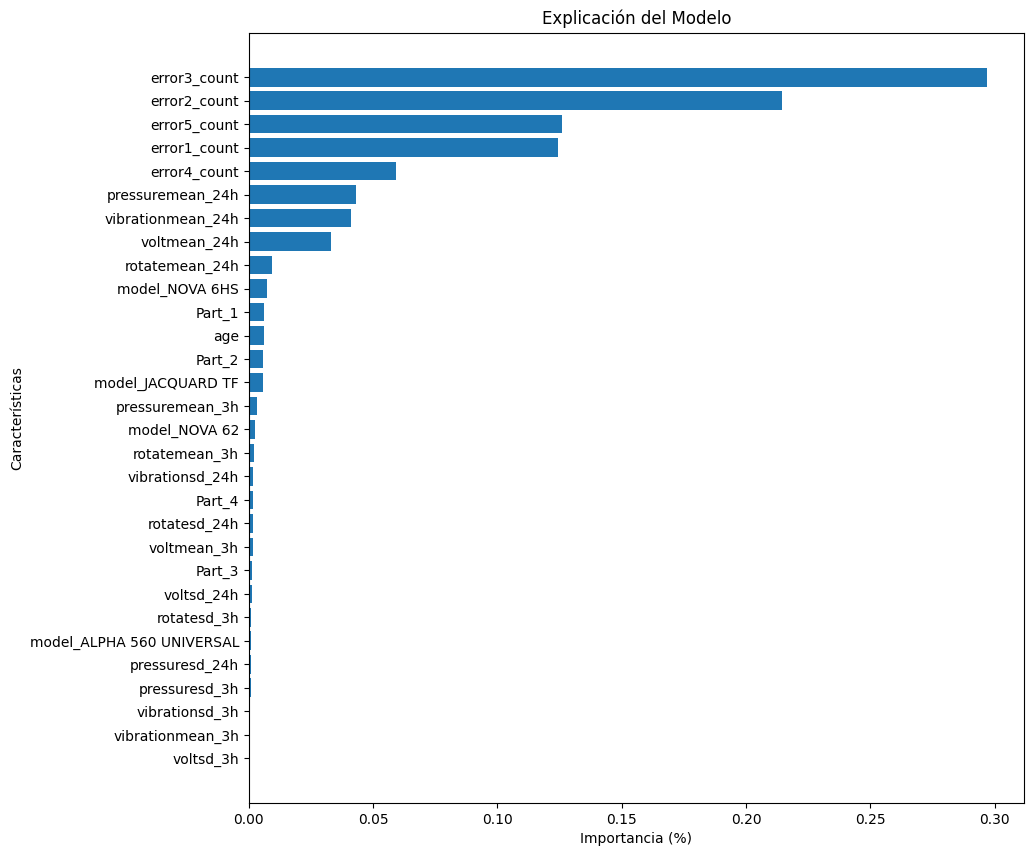

In [75]:
plt.figure(figsize=(10, 10))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=False, key=lambda x: x[1]))
plt.yticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.barh(range(len(importances)), importances)
plt.ylabel("Características")
plt.xlabel("Importancia (%)")
plt.title("Explicación del Modelo")
plt.show()

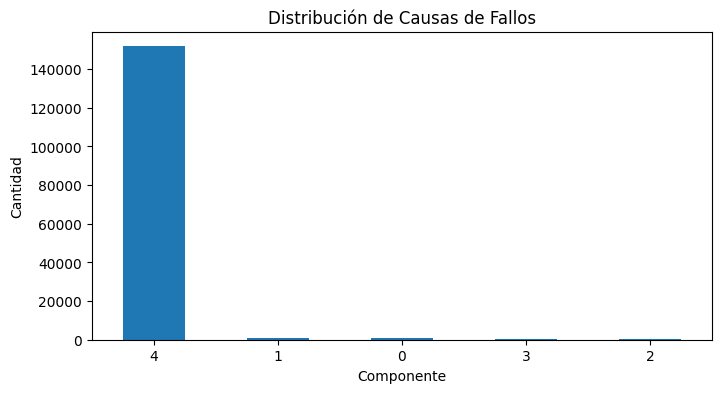

In [76]:
plt.figure(figsize=(8, 4))
final_df_labels["failure"].value_counts().plot(kind="bar", rot=0)
plt.title("Distribución de Causas de Fallos")
plt.xlabel("Componente")
plt.ylabel("Cantidad")
plt.show()

In [77]:
 model.predict(test_X)

array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

In [78]:
from sklearn.metrics import classification_report, confusion_matrix 
print(classification_report(test_y, model.predict(test_X)))
print(confusion_matrix(test_y,model.predict(test_X)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       161
           1       0.91      0.98      0.94       233
           2       1.00      0.89      0.94        95
           3       0.98      0.98      0.98       116
           4       1.00      1.00      1.00     38512

    accuracy                           1.00     39117
   macro avg       0.96      0.97      0.96     39117
weighted avg       1.00      1.00      1.00     39117

[[  156     5     0     0     0]
 [    0   229     0     0     4]
 [    0     0    85     0    10]
 [    1     1     0   114     0]
 [   12    17     0     2 38481]]


In [79]:
model.predict(test_X)

array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

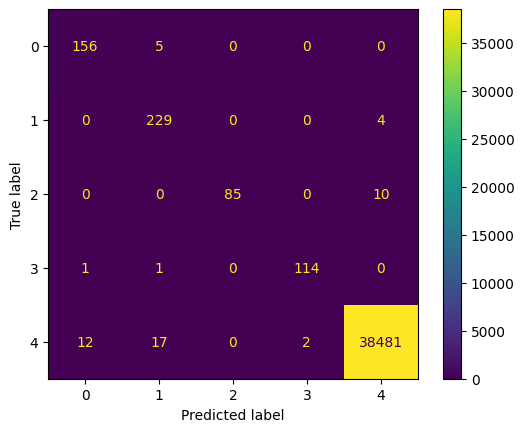

In [80]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = confusion_matrix(test_y.to_numpy(), 
                                    model.predict(test_X))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

## Donde 4 = None, 0 = Part_1, 1 = Part_2, 2 = Part_3, 3 = Part_4, donde cada Part es la parte que falla de la máquina.

A pesar del fuertísimo "*Data Imbalance*" El modelo predice muy bien, seguramente porque la **mezcla** de features SI debe estar muy bien correlacionada con la posibilidad de una falla, lo cual iene sentido cuando vemos la importancia de las características del modelo, en el gráfico de arriba.